In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')

/tmp/ipython-input-1462502802.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [3]:
dataset = data['Close'].values
dataset = dataset.reshape(-1, 1)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [6]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

In [7]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [8]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0192
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0020
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0016
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0015
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0014
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0014
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0013
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 9.8773e-04
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0011
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 9.7159e-04
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.

In [12]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step


In [13]:
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)

In [14]:

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 4610.3387936575355
Mean Absolute Error (MAE): 3629.342917520492


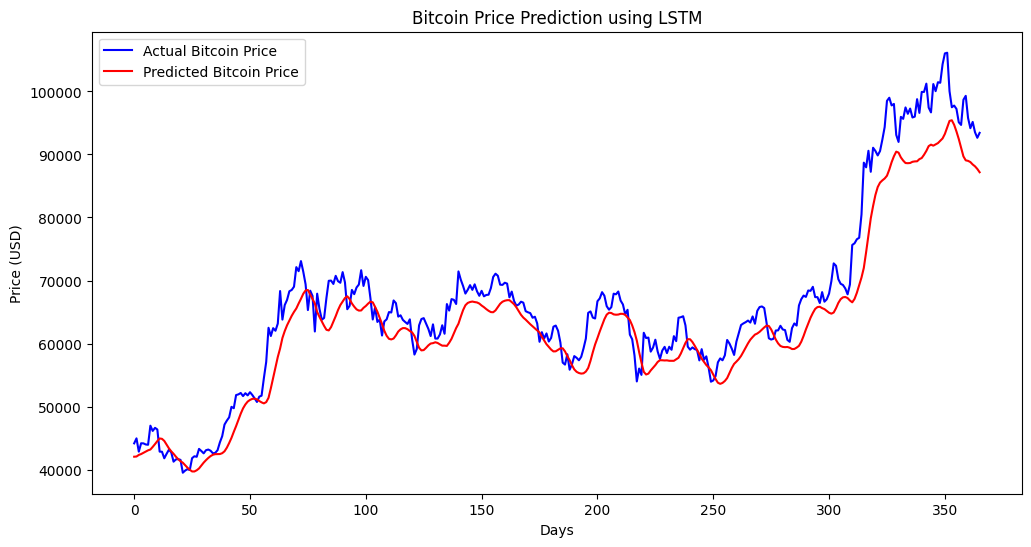

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, color='blue', label='Actual Bitcoin Price')
plt.plot(predictions, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()